# setup

In [30]:
import socket
import os
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import tuning_fun as tu
import emulator_fun as ef
import numpy as np
from tqdm.keras import TqdmCallback
import pandas as pd
import time
import netCDF4 as nc
import load_ppe_fun as lp
from tensorflow.keras import layers
import keras
from tensorflow.keras.losses import Loss
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import TerminateOnNaN
from scipy.stats import boxcox
from tqdm.auto import tqdm
import MCMC_fun as mf
import util_fun as uf
import importlib
import tensorflow_probability as tfp

In [2]:
# set up and check if GPU is used

hostname = socket.gethostname()
if hostname == 'simurgh':
    os.environ["CUDA_VISIBLE_DEVICES"] = "MIG-b5356651-0d8e-5cd1-bdf3-ccbb8b221031"

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
        #     tf.config.experimental.set_virtual_device_configuration(
        #     gpu,
        #     [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=20480)]
        # )
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

print(gpus)

Physical devices cannot be modified after being initialized
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# HP tuning

## pre-processing

In [10]:
importlib.reload(ef)

<module 'emulator_fun' from '/pscratch/sd/a/arthurhu/BOSS_PPE/emulator_fun.py'>

In [11]:
run_name = 'fullmp_ppe_last2hrmean'
filename = run_name + '_N2500.nc'

params_train = ef.get_params(lp.nc_dir, filename)
transform_method = 'standard_scaler'
x_train, x_val, y_train, y_val, tgt_data, tgt_initvar_matrix, ppe_info, scalers = \
    ef.get_train_val_tgt_data(lp.nc_dir, filename, params_train, transform_method, 
                              l_multi_output=True, set_nan_to_neg1001=True)

nobs = ppe_info['nobs']
nvar = ppe_info['nvar']
npar = ppe_info['npar']
n_init = ppe_info['n_init']
nparam_init = ppe_info['nparam_init']

Transforming data...: 100%|██████████| 5/5 [00:00<00:00, 2728.53it/s]


In [58]:
# fig = plt.figure(figsize=(15, 5))
# gs = gridspec.GridSpec(1,nvar)
# for i, eff0 in enumerate(eff0s):
#     ax = fig.add_subplot(gs[i])
#     _ = plt.hist([ppe_data[i].flatten(), tgt_data[i].flatten()],
#                  bins=100,
#                  density=True,
#                  label=['BOSS PPE', 'target'])
#     plt.legend()
#     # plt.yscale('log')
#     plt.title(var_constraints[i])

Next, try out different ML architectures...

## CRPS

In [59]:
importlib.reload(tu)

<module 'tuning_fun' from '/home/arthurhu/BOSS_PPE/tuning_fun.py'>

In [15]:
proj_name = 'crps_' + run_name + '_' + transform_method
varcons = ppe_info['var_constraints']
y_train_nopres = {k: v for k, v in y_train.items() if 'presence_' not in k}
y_val_nopres = {k: v for k, v in y_val.items() if 'presence_' not in k}

nparam_init = ppe_info['nparam_init']
tuner = kt.RandomSearch(
    lambda hp: tu.build_reg_crps_model(hp, nparam_init, varcons, nobs),
    objective="val_loss",
    max_trials=25,
    directory='hp_tuning/crps',
    project_name=proj_name,
)

stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tuner.search(
    x_train,
    y_train_nopres,
    epochs=25,
    validation_data=(x_val, y_val_nopres),
    callbacks=([stop_early, TerminateOnNaN()])
)

# Retrieve the best hyperparameters and build the best model:
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hp)

Trial 25 Complete [00h 00m 17s]
val_loss: 1.000298261642456

Best val_loss So Far: 0.9619903564453125
Total elapsed time: 00h 07m 34s


In [16]:
best_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 24)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      1,600 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 128)       │      8,320 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │     33,024 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ M0_last2hrmean      │ (None, 2)         │        514 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ M3_last2hrmean      │ (None, 2)         │        514 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ M4_last2hrmean      │ (None, 2)         │        514 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ M6_last2hrmean      │ (None, 2)         │        514 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ prate_dm_last2hrme… │ (None, 2)         │        514 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 45,514 (177.79 KB)

 Trainable params: 45,514 (177.79 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=50)

history = best_model.fit(
    x=x_train,
    y=y_train_nopres,
    epochs=1000,
    verbose=0,
    validation_data=(x_val, y_val_nopres),
    callbacks=[TqdmCallback(verbose=1), stop_early]
)

# save model:
best_model.save(f'models/{proj_name}.keras')

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

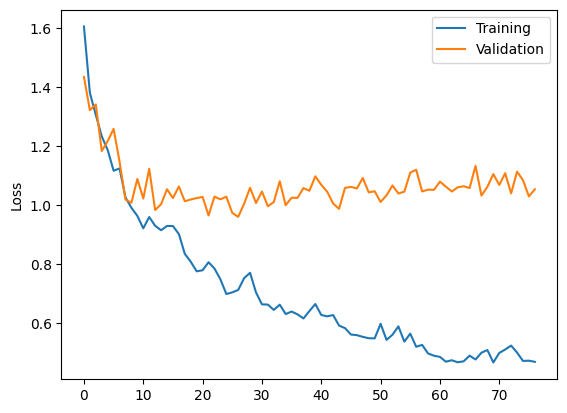

In [18]:
plt.figure()
plt.plot(history.epoch, history.history['loss'], label='Training')
plt.plot(history.epoch, history.history['val_loss'], label='Validation')
plt.ylabel('Loss')
plt.legend()

## multi-output (explicit) model

In [5]:
importlib.reload(tu)

<module 'tuning_fun' from '/home/arthurhu/BOSS_PPE/tuning_fun.py'>

In [ ]:
proj_name = 'multioutput_unc_' + run_name + '_' + transform_method
varcons = ppe_info['var_constraints']
nparam_init = ppe_info['nparam_init']
tuner = kt.RandomSearch(
    lambda hp: tu.build_classreg_unc_model_simple(hp, nparam_init, varcons, nobs),
    objective="val_loss",
    max_trials=25,
    directory='hp_tuning/multi-output',
    project_name=proj_name,
)

stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tuner.search(
    x_train,
    y_train,
    epochs=25,
    validation_data=(x_val, y_val),
    callbacks=([stop_early, TerminateOnNaN()])
)

# Retrieve the best hyperparameters and build the best model:
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hp)

Trial 25 Complete [00h 01m 47s]
val_loss: 1.1667722463607788

Best val_loss So Far: 1.065772294998169
Total elapsed time: 01h 13m 25s


In [7]:
best_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 18)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 96)        │      1,824 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 192)       │     18,624 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 192)       │     37,056 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 96)        │     18,528 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 160)       │     15,520 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ M0 (Dense)          │ (None, 85680)     │ 13,794,480 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ M3 (Dense)          │ (None, 85680)     │ 13,794,480 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Mx (Dense)          │ (None, 85680)     │ 13,794,480 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ My (Dense)          │ (None, 85680)     │ 13,794,480 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ presence_M0 (Dense) │ (None, 42840)     │  6,897,240 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ presence_M3 (Dense) │ (None, 42840)     │  6,897,240 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ presence_Mx (Dense) │ (None, 42840)     │  6,897,240 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ presence_My (Dense) │ (None, 42840)     │  6,897,240 │ dense_9[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 82,858,432 (316.08 MB)

 Trainable params: 82,858,432 (316.08 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=50)

history = best_model.fit(
    x=x_train,
    y=y_train,
    epochs=10000,
    verbose=0,
    validation_data=(x_val, y_val),
    callbacks=[TqdmCallback(verbose=1), stop_early]
)

# save model:
best_model.save(f'models/{proj_name}.keras')

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

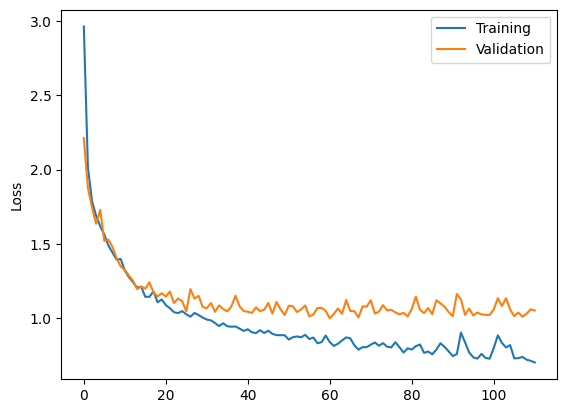

In [9]:
plt.figure()
plt.plot(history.epoch, history.history['loss'], label='Training')
plt.plot(history.epoch, history.history['val_loss'], label='Validation')
plt.ylabel('Loss')
plt.legend()

## validation

In [19]:
# proj_name = 'multioutput_condcoal_46_momvals_standard_scaler_asinh'
# best_model = tf.keras.models.load_model('models/' + proj_name + '.keras', compile=False)
# proj_name


In [20]:
importlib.reload(ef)

<module 'emulator_fun' from '/pscratch/sd/a/arthurhu/BOSS_PPE/emulator_fun.py'>

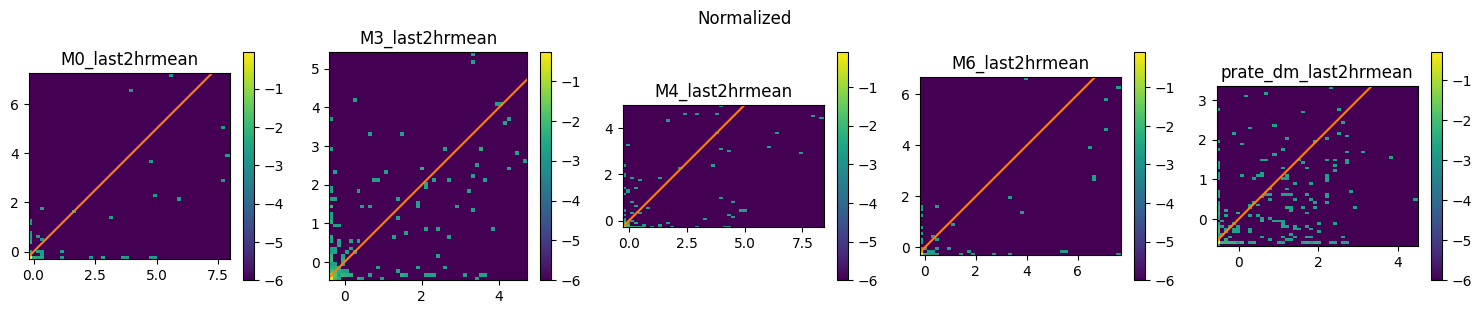

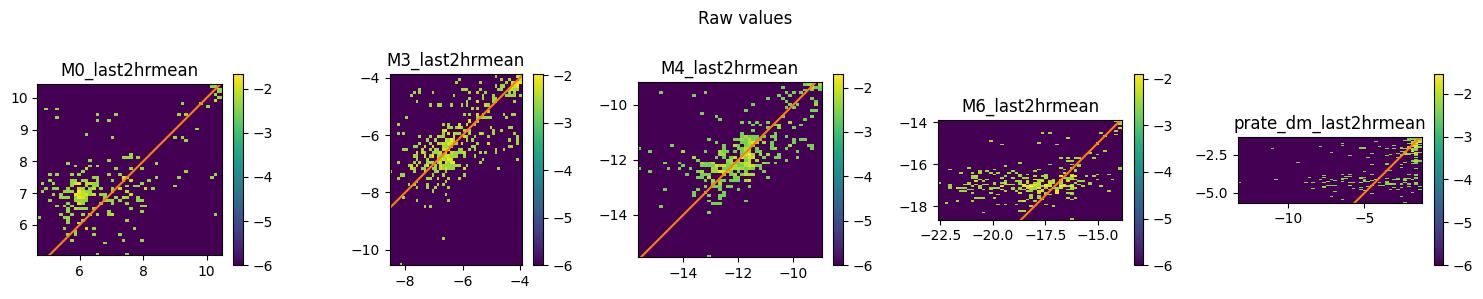

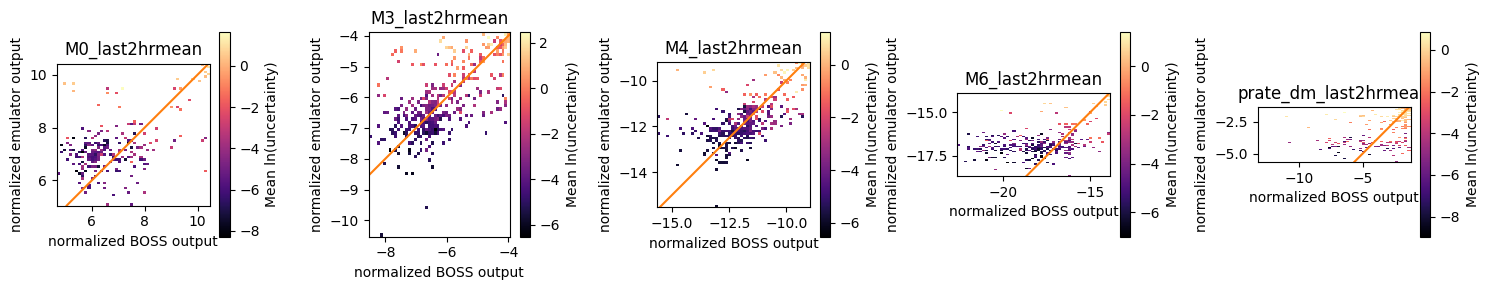

In [21]:
ef.plot_emulator_results(x_val, y_val, best_model, ppe_info, transform_method, scalers, plot_uncertainty=True)

In [22]:
# List top memory variables
# top_vars = uf.get_top_memory_vars(globals())
uf.detailed_memory_analysis()
# # Free likely iterated/temporary variables
# free_iterated_vars(locals())

# # Optionally, show top memory variables again after cleanup
# print("\nAfter cleanup:")
# get_top_memory_vars(locals())

=== Memory Analysis ===
RSS (Resident Set Size): 6.32 GB
VMS (Virtual Memory Size): 70.03 GB
Shared Memory: 0.45 GB
Text Segment: 0.00 GB
Data Segment: 10.57 GB

⚠️  Large VMS-RSS gap: 63.71 GB
This might indicate memory fragmentation or external libraries


# MCMC

## setup

In [23]:
# proj_name = 'crps_condcoal_46_momvals_standard_scaler_asinh'
# best_model = tf.keras.models.load_model('models/' + proj_name + '.keras', compile=False)

In [45]:
# MCMC
nchains = 8
num_burnin_steps = 5000
num_samples = 10000

# log prob function related
tau = 0.05
inflate_factor = 5.

In [46]:
params_train

{'pnames': array(['a0evap1_db', 'a0evap2_db', 'bm0evap1', 'bm0evap2', 'bx0evap1',
        'bx0evap2', 'by0evap1', 'by0evap2', 'aevap_db', 'bmevap',
        'bx3evap', 'bxxevap', 'bxyevap', 'by3evap', 'byxevap', 'byyevap',
        'a0coal_db', 'bmcoal', 'bncoal', 'bx0coal', 'bxscoal', 'bxxcoal',
        'bxycoal', 'by0coal', 'byscoal', 'byxcoal', 'byycoal',
        'mtrans0_db', 'afall_db', 'bnfall', 'bx0fall', 'bx3fall',
        'bxxfall', 'bxyfall', 'by0fall', 'by3fall', 'byxfall', 'byyfall',
        'mlim_db'], dtype=object),
 'vals': masked_array(
   data=[[ 6.32220080e+07, -8.84991330e+01,  1.29238800e+00, ...,
           1.02634900e+00,  1.54321500e+00,  1.24520220e+01],
         [ 1.12523850e+07, -8.04723050e+01,  7.65580000e-01, ...,
          -2.45482000e-01,  3.88507100e+00,  1.28543570e+01],
         [ 1.06822064e+08, -9.57837570e+01,  8.40549000e-01, ...,
           3.28606400e+00,  2.29536500e+00,  3.29287600e+00],
         ...,
         [ 7.59234640e+07, -8.56182850e+01,  

In [47]:
tgt_data_tf32 = tf.cast(tgt_data, tf.float32)
param_interest_idx = params_train['param_interest_idx']

orig_param_csv = '/global/homes/a/arthurhu/CloudBOSS/param_csv/param_consolid_offline.csv'
# target_param_csv = '/home/arthurhu/CloudBOSS/param_csv/param_test.csv'

param_table = pd.read_csv(orig_param_csv)
param_names = param_table.columns[1+param_interest_idx].to_list()

# target_param_table = pd.read_csv(target_param_csv)

param_mean = param_table.values[0, 1+param_interest_idx].astype(np.float32)
param_std = param_table.values[1, 1+param_interest_idx].astype(np.float32)
# target_param_mean = target_param_table.values[0, 1+param_interest_idx].astype(np.float32)
nparam = len(param_names)

print_table = pd.DataFrame({'param names': param_names, 'prior mean': param_mean})
print(print_table)

   param names  prior mean
0    a0coal_db  -86.874352
1       bmcoal    1.114861
2       bncoal    2.220380
3      bx0coal    0.966567
4      bxscoal    0.985066
5      bxxcoal    1.443240
6      bxycoal    2.453892
7      by0coal    0.881915
8      byscoal   -0.001866
9      byxcoal    2.301591
10     byycoal    4.374075
11  mtrans0_db   -5.055394
12    afall_db    8.679640
13      bnfall    1.542066
14     bx0fall   -0.383535
15     bx3fall    0.937090
16     bxxfall    0.878926
17     bxyfall    0.733513
18     by0fall   -0.024706
19     by3fall    0.510425
20     byxfall    1.387850
21     byyfall    2.727749
22     mlim_db    9.035962


In [48]:
tgt_sim_ics = np.concatenate(tgt_initvar_matrix, axis=1)
nvar = len(ppe_info['var_constraints'])
n_tgt_ics = tgt_data[0].shape[0]

IC_with_dummy = np.concatenate((tgt_sim_ics, np.zeros([n_tgt_ics, npar])), axis=1)
IC_norm = scalers['x'].transform(IC_with_dummy)[:,:n_init].astype('float32')
IC_norm_3d = tf.tile(IC_norm[None, :, :], [nchains, 1, 1])
batch_size = nchains * n_tgt_ics
tgt_data_tf32_chain = tf.tile(tgt_data_tf32[None, :, :, :], [nchains, 1, 1, 1])
varcons = ppe_info['var_constraints']

## set up log prob function

In [49]:
tfd = tfp.distributions
tfb = tfp.bijectors
tfs = tfp.experimental.stats

def get_BOSSemu_lp(params_sigma, l_diag=False):
    emu_mu_list, emu_sigma_list, emu_pres_list, obs_score_list = [], [], [], []
    
    # priors on parameters

    params = params_sigma
    params_3d = tf.tile(params[:, None, :], [1, n_tgt_ics, 1])
    theta=tfb.Sigmoid().forward(params_3d)
    param_lp = tf.reduce_sum(tf.math.log(theta) + tf.math.log1p(-theta), axis=[1,2])

    if l_diag:
        # print('input:', params_3d[0,0,:].numpy())
        print('scaled parameters:', theta[0,0,:].numpy())

    # likelihood
    input_norm3d = tf.concat([IC_norm_3d, theta], axis=-1) # nchains x n_tgt_ics x n_input
    input_norm2d  = tf.reshape(input_norm3d, [batch_size, nparam_init])
    y_emu = best_model(input_norm2d) # nvar * n_tgt_ics x nobs
    if type(y_emu) is dict:
        for i, varcon in enumerate(varcons):
            pres = tf.ones([nchains, n_tgt_ics, nobs[i]], tf.float32)
            if f'presence_{varcon}' in y_emu.keys():
                pres   = tf.reshape(tf.cast(y_emu[f'presence_{varcon}'], tf.float32),
                                    [nchains, n_tgt_ics, nobs[i]])
            full   = tf.reshape(tf.cast(y_emu[varcon], tf.float32),
                                [nchains, n_tgt_ics, 2*nobs[i]])
            mu     = full[..., :nobs[i]]
            rawsig = full[..., nobs[i]:]  # raw scale; softplus later
            emu_pres_list.append(pres)
            emu_mu_list.append(mu)
            emu_sigma_list.append(rawsig)
        emu_tf32_presence_chain = tf.transpose(tf.stack(emu_pres_list),  [1,0,2,3])  # [chain, var, ic, obs]
        emu_mu_chain            = tf.transpose(tf.stack(emu_mu_list),    [1,0,2,3])
        emu_sigma_chain         = tf.transpose(tf.stack(emu_sigma_list), [1,0,2,3])
    else:
        raise ValueError('`y_emu` is not a dictionary. Not yet implemented.')

    for ichain in range(nchains):
        presence_pred = emu_tf32_presence_chain[ichain, ...]   # [nvar, n_ic, nobs]
        mu_pred       = emu_mu_chain[ichain, ...]
        sig_pred      = emu_sigma_chain[ichain, ...]
        y_true        = tgt_data_tf32                          # [nvar, n_ic, nobs]

        finite_mask = tf.math.is_finite(y_true)
        finite_w    = tf.stop_gradient(tf.cast(finite_mask, tf.float32))

        # soft presence gate (same as you had)
        thresh = tf.constant(0.1, tf.float32)
        tau    = tf.constant(0.05, tf.float32)
        w_soft = tf.sigmoid((presence_pred - thresh) / tau)

        w = finite_w * w_soft

        # safe tensors
        y_true_safe = tf.where(finite_mask, y_true, 0.0)
        mu_safe     = tf.where(finite_mask, mu_pred, 0.0)
        sig_safe    = tf.where(finite_mask, sig_pred, 0.0)

        # CRPS per point (univariate, closed form)
        crps = mf.gaussian_crps_per_point(y_true_safe, mu_safe, sig_safe)  # [nvar, n_ic, nobs]

        # weighted sum; use your ratio (or lambda), but avoid using both aggressively
        # w_sum = tf.reduce_sum(w) + 1e-6
        score_chain = tf.reduce_sum(w * crps)   # average CRPS over active points
        obs_score_list.append(-score_chain)  # negative because we return log "likelihood"
    
    obs_lp = tf.stack(obs_score_list)                   # shape [nchains]
        
    if l_diag:
        print('param_lp:', param_lp.numpy().mean(), 'obs_lp:', inflate_factor * obs_lp.numpy().mean())
        return param_lp, obs_lp * inflate_factor, crps, w, y_true_safe, mu_pred
    else:
        return param_lp + obs_lp * inflate_factor

In [50]:
tf.random.set_seed(1)
initial_state = tf.random.normal([nchains, npar], seed=1) * 0.1
param_lp, obs_lp, crps, w, y_true_safe, mu_safe = get_BOSSemu_lp(initial_state, l_diag=True)

# target_param_mean_2d = np.tile(target_param_mean, (n_tgt_ics, 1))
# target_param_withIC = np.concatenate((tgt_sim_ics, target_param_mean_2d), axis=1)
# target_pwIC_norm = scalers['x'].transform(target_param_withIC)
# target1d = tf.concat([tfb.Sigmoid().inverse(target_pwIC_norm[0,n_init:]), [0]], axis=0)
# target1d = tfb.Sigmoid().inverse(target_pwIC_norm[0,n_init:])
# target_chain = tf.cast(tf.tile(target_pwIC_norm[0,n_init:][None, :], [nchains, 1]), tf.float32)
# a = get_BOSSemu_lp(target_chain, l_diag=True)
# initial_state = tf.zeros([nchains, npar])
# param_lp, obs_lp, logpdf, noise_scale_list, weight_list = get_BOSSemu_lp(initial_state, l_diag=True)
# initial_state = tf.concat([tf.fill([nchains, npar], 0.5), initial_state[:, -1][:, None]], axis=1)
# get_BOSSemu_lp(initial_state, l_diag=True)
# initial_state = tf.concat([tf.fill([nchains, npar], -0.5), initial_state[:, -1][:, None]], axis=1)
# get_BOSSemu_lp(initial_state, l_diag=True)

scaled parameters: [0.5070454  0.5594137  0.55676436 0.49228406 0.48881233 0.47983226
 0.50400895 0.4915762  0.5116325  0.46881542 0.5234411  0.46794268
 0.49170607 0.49978647 0.48769197 0.5227555  0.5127583  0.4826047
 0.5388076  0.5070896  0.50407624 0.4998751  0.481662  ]
param_lp: -223.56999 obs_lp: -158.08485


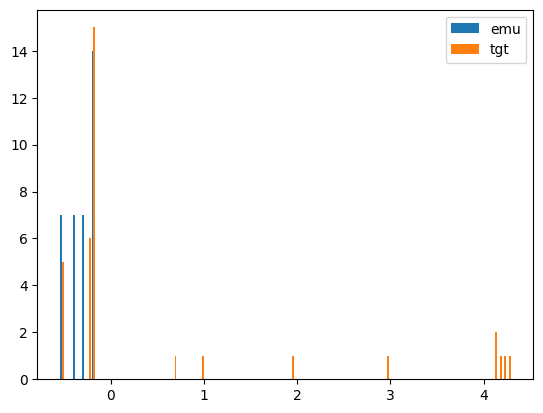

In [51]:
# ivar = 4
# filtered = w.numpy().flatten()>0.5
emu_vs_tgt = [mu_safe.numpy().flatten(), y_true_safe.numpy().flatten()]
_ = plt.hist(emu_vs_tgt, bins=100)
plt.legend(['emu', 'tgt'])

In [52]:
# Static diagonal preconditioner - pilot run to estimate sigma

initial_state = tf.random.normal([nchains, npar], seed=1) * 0.1
pilot_hmc = tfp.mcmc.HamiltonianMonteCarlo(get_BOSSemu_lp, step_size=0.0005, num_leapfrog_steps=5)
@tf.function
def run_pilot_chain():
    return tfp.mcmc.sample_chain(num_results=100, num_burnin_steps=0,
                                   current_state=initial_state, kernel=pilot_hmc, 
                                   trace_fn=(lambda current_state, kernel_results: kernel_results), 
                                   seed=1)
z_pilot, kr_pilot = run_pilot_chain()

var = tf.math.reduce_variance(z_pilot, axis=[0,1]) + 1e-6
sigma = tf.sqrt(var)  # shape [npar]
print(sigma)

tf.Tensor(
[0.10424692 0.08855654 0.09751931 0.04478306 0.08395404 0.05622662
 0.07586702 0.10323351 0.13770556 0.1256722  0.11679434 0.09122592
 0.12386911 0.1101879  0.1006294  0.12899481 0.11581924 0.09352139
 0.08670261 0.09151406 0.11347447 0.0540882  0.09194338], shape=(23,), dtype=float32)


## actual run

In [53]:

stepsize = 0.1
bij = tfb.Blockwise([tfb.Sigmoid()] * npar)
rv0 = tfs.RunningVariance.from_stats(
    num_samples=tf.constant(0., initial_state.dtype),   # “empty” running variance
    mean=tf.zeros([npar], initial_state.dtype),
    variance=tf.ones([npar], initial_state.dtype),         # start with I
)

hmc = tfp.mcmc.HamiltonianMonteCarlo(get_BOSSemu_lp, step_size=stepsize, num_leapfrog_steps=3)
DA = tfp.mcmc.DualAveragingStepSizeAdaptation(
        inner_kernel=hmc,
        num_adaptation_steps=int(num_burnin_steps * 0.5),
        target_accept_prob=0.75,
        )

precond = tfp.bijectors.Scale(sigma)

TTK = tfp.mcmc.TransformedTransitionKernel(
    bijector=precond,
    inner_kernel=DA,
)
# DMMA = tfp.experimental.mcmc.DiagonalMassMatrixAdaptation(
#     inner_kernel=DA,
#     initial_running_variance=[rv0],
#     num_estimation_steps=int(0.8*num_burnin_steps),
# )

nuts = tfp.mcmc.NoUTurnSampler(target_log_prob_fn=get_BOSSemu_lp, step_size=stepsize, max_tree_depth=10)
adaptive_nuts = tfp.mcmc.DualAveragingStepSizeAdaptation(
    inner_kernel=nuts,
    num_adaptation_steps=int(num_burnin_steps * 0.5),
    target_accept_prob=0.65,
)

# Improved MCMC settings
# stepsize = 0.1
# num_burnin_steps = 200
# num_samples = 500

# nuts = tfp.mcmc.NoUTurnSampler(target_log_prob_fn=get_BOSSemu_lp, 
#                                step_size=stepsize, 
#                                max_tree_depth=10)
# adaptive_nuts = tfp.mcmc.DualAveragingStepSizeAdaptation(
#     inner_kernel=nuts,
#     num_adaptation_steps=int(num_burnin_steps * 0.8),
#     target_accept_prob=0.65,
# )

start = time.time()

@tf.function
def run_chain():
    return tfp.mcmc.sample_chain(num_results=num_samples,
        current_state=initial_state,   # or your initial_state
        kernel=TTK,
        num_burnin_steps=num_burnin_steps,
        trace_fn=(lambda current_state, kernel_results: kernel_results),
        seed=0)

samples, kr = run_chain()

end = time.time()
print(end-start)

130.263689994812


acceptance rate: [0.8346 0.8161 0.8168 0.83   0.8339 0.8394 0.8466 0.8083]


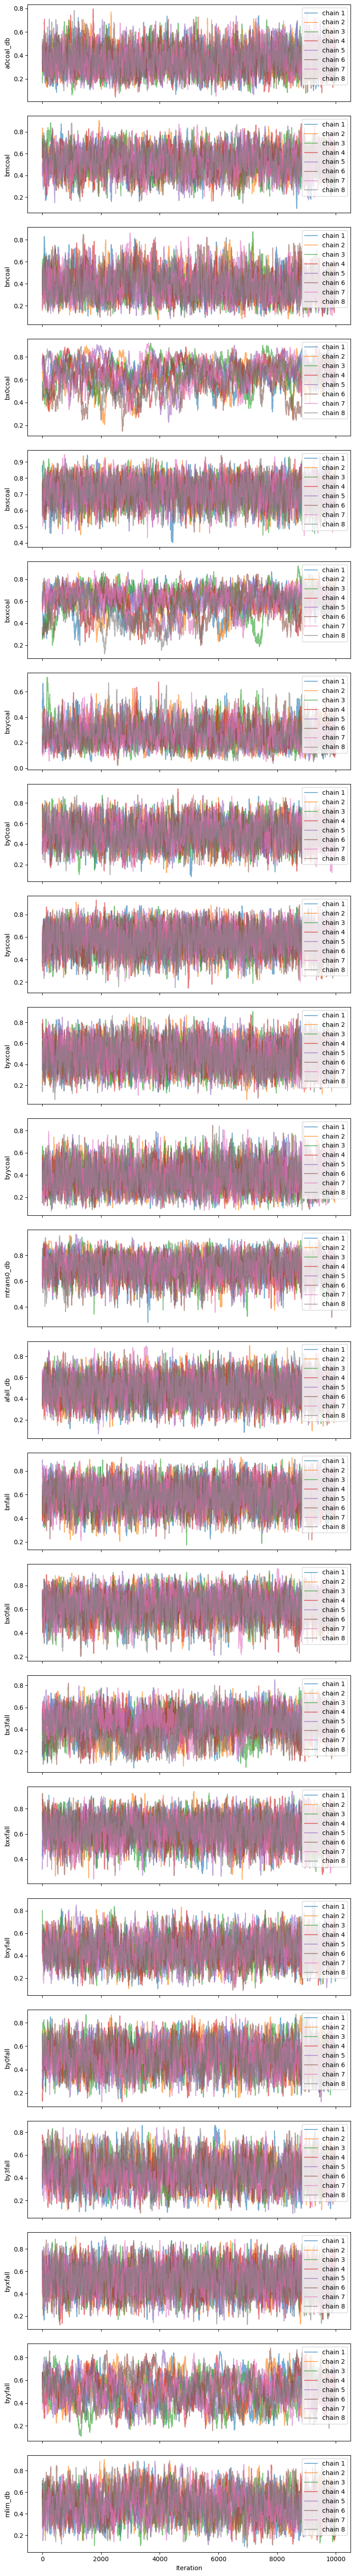

[[227.247    170.79013  115.10942   51.302383 198.70934   56.219765
  140.70831  220.31206  291.46848  288.68066  293.40332  177.09346
  304.2709   282.80637  201.3346    98.20026  227.81902  175.12025
  202.89604  121.60347  311.6792    67.35655   73.27929 ]
 [209.02011  120.85934   64.54253   43.182377 107.295746  44.80008
   51.287624 137.7275   307.15747  127.61092  257.78998  109.73152
  223.3548   210.49219  145.11961   56.61283  179.95403  132.70691
  116.887054 204.83157  268.3802    63.26219   94.26182 ]
 [221.66466  162.04305  147.74084   44.588715 216.63785   28.608076
   82.985695 216.67902  249.3611   253.84264  356.18353  161.68933
  321.2925   212.19664  214.63257   35.182278 277.11603  192.15663
  149.51695  191.8397   347.7644    43.547367 109.76941 ]
 [241.74939  189.61185   55.627937  34.5383   229.20764   40.298363
  124.02006  252.895    278.37265  212.04643  273.33868  270.4519
  287.45874  253.52649  124.178314  53.82212  274.94702  160.3058
  198.8473   198.4638

In [54]:
print("acceptance rate:", sum(kr.inner_results.inner_results.is_accepted.numpy())/num_samples)
# param_names_incl_sigma = param_names + ['sigma']
transformed_samples = tfb.Sigmoid().forward(samples)
# transformed_samples = tf.concat([tfb.Sigmoid().forward(samples[:,:,:-1]), tf.exp(samples[:,:,-1:])], axis=2)
mf.plot_traces(transformed_samples, param_names)

print(tfp.mcmc.effective_sample_size(samples).numpy())
print(tfp.mcmc.potential_scale_reduction(samples).numpy())

In [55]:
print("acc rate:", kr.inner_results.inner_results.is_accepted.numpy().mean())
# print("step_size:", kr.inner_results.step_size.numpy())
print("step_size range:", kr.inner_results.new_step_size.numpy().min(), kr.inner_results.new_step_size.numpy().max())
# print("leapfrog steps avg:", kr.inner_results.leapfrogs_taken.numpy().mean()).
print("avg log_accept_ratio:", np.nanmean(kr.inner_results.inner_results.log_accept_ratio))

acc rate: 0.8282125
step_size range: 0.5787762 0.5787762
avg log_accept_ratio: -0.28603622


In [56]:
with tf.GradientTape() as gt:
  gt.watch(initial_state)
  logprob = get_BOSSemu_lp(initial_state)
grad = gt.gradient(logprob, initial_state)
print("||grad|| ≈", tf.norm(grad).numpy())

||grad|| ≈ 7.846154


In [57]:
with tf.GradientTape() as t:
    t.watch(initial_state)                # unconstrained params you sample in
    lp = get_BOSSemu_lp(initial_state)
g = t.gradient(lp, initial_state)         # shape [..., D]
gn = tf.math.reduce_std(g, axis=0)  # per-dim
print(gn)

tf.Tensor(
[0.26406515 0.33816323 0.3308788  0.377656   0.39309183 0.3075983
 0.7049351  0.35907173 0.46875224 0.40442443 0.47957087 0.8232056
 0.44603932 0.34473377 0.35868448 0.30640236 0.47341207 0.28850687
 0.29640839 0.39786512 0.33061662 0.286114   0.3632282 ], shape=(23,), dtype=float32)


## postprocessing

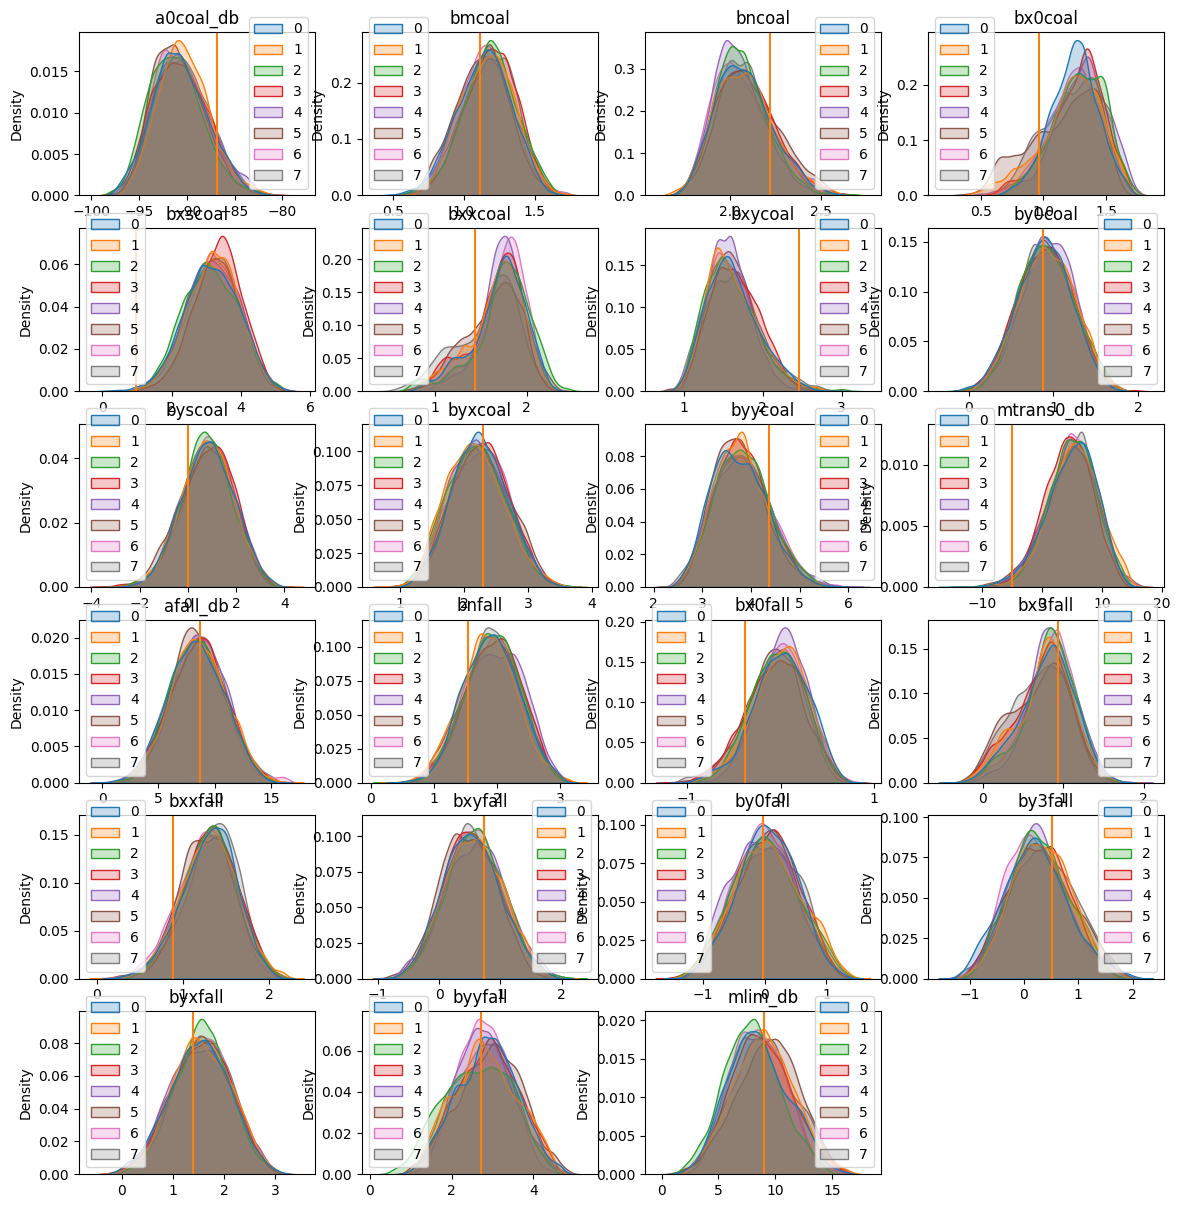

In [58]:
import seaborn as sns

IC_col = tf.tile(tf.expand_dims(IC_norm[0, :n_init], 0), [num_samples, 1])
# IC_col = tf.tile(tf.expand_dims(IC_norm[0, :n_init], 0), [num_samples, 1])
IC_col3d = tf.tile(IC_col[:, None, :], [1, nchains, 1])
# w_col3d = tf.tile(w_col[:, None, :], [1, nchains, 1])
samples_with_ic = tf.concat([IC_col3d, transformed_samples], axis=2)

samples_with_ic_raw_vals = np.zeros(samples_with_ic.shape, dtype=np.float32)
for ichain in range(nchains):
    samples_with_ic_raw_vals[:, ichain, :] = scalers['x'].inverse_transform(samples_with_ic[:, ichain, :])

samples_raw_vals = samples_with_ic_raw_vals[:,:,n_init:]

np.mean(samples_with_ic[:,:,n_init:].numpy().reshape(num_samples*nchains,nparam), axis=0)
# samples_with_ic[:,:,n_init:].shape

samples_origval = samples_raw_vals
fig = plt.figure(figsize=(14,25))
gs = gridspec.GridSpec(10, 4)
for ipost in range(samples_origval.shape[-1]):
# for iparam, param_name in enumerate(param_names):
    param_name = param_names[ipost]
    ax = fig.add_subplot(gs[ipost])
    sns.kdeplot(samples_origval[:,:,ipost], fill=True)
    plt.axvline(param_mean[ipost], color='tab:orange')
    # plt.axvline(target_param_mean[ipost], color='tab:blue')
    plt.title(param_name)

$$
\frac{dM_i}{dt} \propto a_{0,coal}M^2_0\frac{\tilde{m}^{b_{n,i}}}{\tilde{m}^{b_{m}} + m_{trans}^{b_m}}K^{b_{x,i}}_{0,3,x}K^{b_{y,i}}_{3,x,y}
$$

x=4, y=6 for ith order moment

## validation

In [59]:
# importlib.reload(ef)

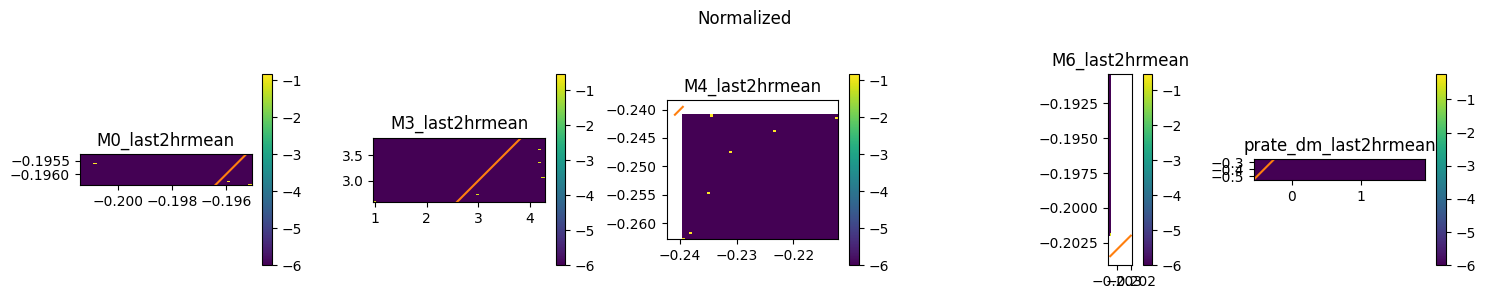

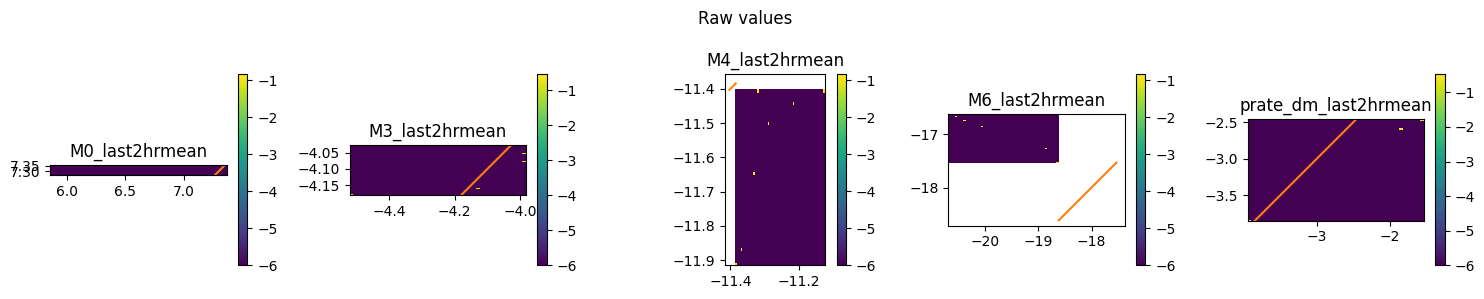

In [60]:
tsamples_combine_chains = transformed_samples.numpy().reshape(num_samples*nchains, npar)
meanresult = np.mean(tsamples_combine_chains, axis=0)
meanresult = tf.expand_dims(meanresult, axis=0)
meanresult_tiled = tf.tile(meanresult, [IC_norm.shape[0], 1])
meanresults_incl_ics = tf.concat([IC_norm, meanresult_tiled], axis=1)

ef.plot_emulator_results(meanresults_incl_ics, tgt_data, best_model, ppe_info, transform_method, scalers)

# Save MCMC results

## save posterior PDF into netCDF

In [61]:
nbins = 50
count = {}
bins = {}
sample_sum_chains = samples_origval.reshape(num_samples*nchains,nparam)
for iparam, param_name in enumerate(param_names):
    count[param_name], bins[param_name] = np.histogram(sample_sum_chains[:, iparam], bins=nbins)
    count[param_name] = count[param_name]/np.sum(count[param_name])

import netCDF4 as nc
import numpy as np

# Create a new NetCDF file
ncfile = nc.Dataset('MCMC_posterior/' + filename[:-3] + '_post.nc', mode='w', format='NETCDF4')

# Create the dimension for parameters and bins
param_dim = ncfile.createDimension('nparam', len(param_names))
binmean_dim = ncfile.createDimension('nbin', nbins)
binedge_dim = ncfile.createDimension('nbinedge', nbins+1)

# Create variables
param_var = ncfile.createVariable('param_names', str, ('nparam',))
density_var = ncfile.createVariable('density', np.float32, ('nparam', 'nbin',))
bin_edges_var = ncfile.createVariable('bin_edges', np.float32, ('nparam', 'nbinedge',))
# sigma_dens_var = ncfile.createVariable('sigma_dens', np.float32, ('nbin',))
# sigma_edge_var = ncfile.createVariable('sigma_edge', np.float32, ('nbinedge',))

# Assign data
param_var[:] = np.array(param_names, dtype='S')
for i, pname in enumerate(param_names):
    # bins[pname] has nbins+1 edges, so we store the left edges for each bin
    density_var[i, :] = count[pname]
    bin_edges_var[i, :] = bins[pname]

# sigma_dens_var[:] = count['sigma'].astype('float32')
# sigma_edge_var[:] = bins['sigma']
ncfile.close()

## update params csv

In [62]:
original_params = pd.read_csv(orig_param_csv)
updated_params = original_params.copy()
for iparam, param_name in enumerate(param_names):
    binmean = (bins[param_name][1:] + bins[param_name][:-1])/2
    weighted_mean = np.average(binmean, weights=count[param_name])
    weighted_std = np.sqrt(np.cov(binmean, aweights=count[param_name], ddof=0))
    updated_params.loc[0, param_name] = weighted_mean
    updated_params.loc[2, param_name] = weighted_std

# coal_density = pd.read_csv('MCMC_posterior/coal_r2_param_density.csv')
# coal_param_names = coal_density.keys()[1:].to_list()
# coal_bin_edges = pd.read_csv('MCMC_posterior/coal_r2_param_bins.csv')

# for iparam, param_name in enumerate(coal_param_names):
#     binmean = (coal_bin_edges[param_name][1:].to_numpy() + coal_bin_edges[param_name][:-1].to_numpy())/2
#     weighted_mean = np.average(binmean, weights=coal_density[param_name])
#     updated_params.loc[0, param_name] = weighted_mean

updated_params.to_csv(orig_param_csv + run_name + '_r1.csv', index=False)
updated_params

Unnamed: 0  a0evap1_db  a0evap2_db  bm0evap1   bm0evap2   bx0evap1  \
0       mean   21.864028  -29.553641 -0.003249  -3.397290   5.420265   
1         sd    2.255964    3.114923  0.003238   0.132059   0.168649   
2        isd  225.596447  311.492309  0.323756  13.205860  16.864912   

    bx0evap2   by0evap1   by0evap2   aevap_db  ...    bnfall   bx0fall  \
0   5.522030  -2.747893  -2.024920 -66.979874  ...  1.915459 -0.031214   
1   0.137407   0.390538   0.169134   0.203477  ...  0.220264  0.013566   
2  13.740731  39.053810  16.913419  20.347684  ...  0.441861  0.295484   

    bx3fall   bxxfall   bxyfall   by0fall   by3fall   byxfall   byyfall  \
0  0.775570  1.294834  0.549971  0.016740  0.280122  1.542904  2.801488   
1  0.014816  0.015543  0.019498  0.019935  0.021920  0.023036  0.028926   
2  0.344396  0.316907  0.465146  0.505023  0.564133  0.574578  0.740258   

    mlim_db  
0  8.674330  
1  0.800699  
2  2.637566  

[3 rows x 40 columns]